In [1]:
import sys

sys.path.append("../../..")

import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import rc
import mpl_toolkits.axes_grid1.inset_locator as inloc
import scipy.stats as stats
import src.energy_effects_t2k.convolution as conv
import src.nu_osc.osc_prob as osc
import src.nu_osc.default_parameters as param

In [2]:
rc("figure", figsize=(10, 5))
# rc('lines', linewidth=2)
rc("axes", labelsize=12, linewidth=1, grid=True, labelpad=-1, axisbelow=True)
rc("axes.spines", right=True)
rc("xtick", direction="in", labelsize=12, top=True)
rc("xtick.major", width=0.8, size=5)
rc("ytick", direction="in", labelsize=12, right=True)
rc("ytick.major", width=0.8, size=5)
rc("legend", fancybox=False, fontsize=12, shadow=False)
rc(
    "grid",
    linewidth=1.0,
)  # ls='dotted')
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
colors = {
    "numu": "darkgreen",
    "antinumu": "darkseagreen",
    "nue": "red",
    "antinue": "rosybrown",
    "nutau": "teal",
    "antinutau": "cadetblue",
}

In [4]:
t2kflux_2020_plus250kA_nominal_sk = conv.fluximport(
    "t2kflux_2020_plus250kA_nominal_sk.csv"
)

In [5]:
ccqe_interp = conv.xsecimport(
    name="neutrino_ccqe.csv",
    mode="true filter interp",
    keep_left=5,
    on=(t2kflux_2020_plus250kA_nominal_sk.minE + t2kflux_2020_plus250kA_nominal_sk.maxE)
    / 2,
)

In [6]:
number = pd.DataFrame()
for key in ["minE", "maxE"]:
    number[key] = t2kflux_2020_plus250kA_nominal_sk[key]
for key in ["numu", "antinumu", "nue", "antinue"]:
    number[key] = (
        (ccqe_interp.xsec * t2kflux_2020_plus250kA_nominal_sk[key] / (50 * 1e21))
        * param.SK_POT["FHC"]
        * param.TOT_NEUTRONS
        * 2
    )

In [7]:
number["nutau"] = 0.0
number["antinutau"] = 0.0

In [8]:
number_oscillated = {
    "bf": conv.oscillate(to_oscillate=number),
    "p1sigma": conv.oscillate(
        to_oscillate=number, dm2_atm=param.NUFIT["Dm_square_32"]["p1sigma"]
    ),
    "m1sigma": conv.oscillate(
        to_oscillate=number, dm2_atm=param.NUFIT["Dm_square_32"]["m1sigma"]
    ),
    "p3sigma": conv.oscillate(
        to_oscillate=number, dm2_atm=param.NUFIT["Dm_square_32"]["p3sigma"]
    ),
    "m3sigma": conv.oscillate(
        to_oscillate=number, dm2_atm=param.NUFIT["Dm_square_32"]["m3sigma"]
    ),
}

In [9]:
ccqe_energy_res_interp = conv.energyimport(
    name="ccqe_energy_res.csv", mode="interp", on=np.linspace(-0.5, 1.0, 125)
)

In [10]:
oscillated_smeared = {}
for key in number_oscillated:
    oscillated_smeared[key] = conv.bias(input=number_oscillated[key], a=0.02)

In [11]:
params = {
    "dm2_atm": [
        param.NUFIT["Dm_square_32"]["m3sigma"],
        param.NUFIT["Dm_square_32"]["p3sigma"],
    ]
}

number_oscillated["min"], number_oscillated["max"] = (
    number_oscillated["m3sigma"],
    number_oscillated["p3sigma"],
)
oscillated_smeared["min"], oscillated_smeared["max"] = (
    oscillated_smeared["m3sigma"],
    oscillated_smeared["p3sigma"],
)

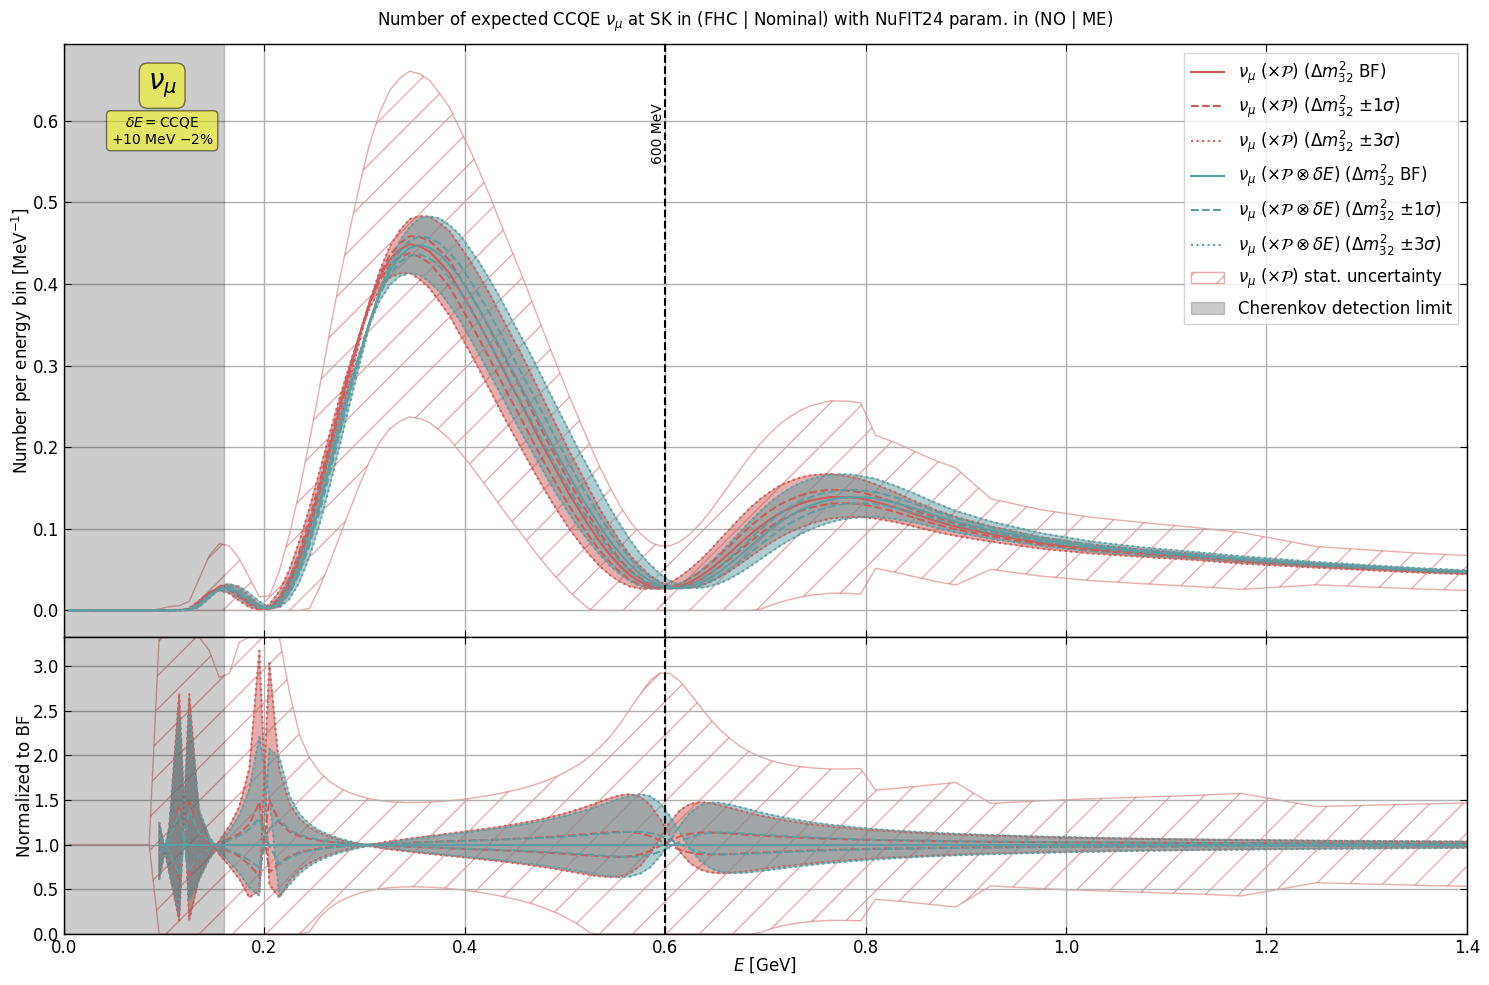

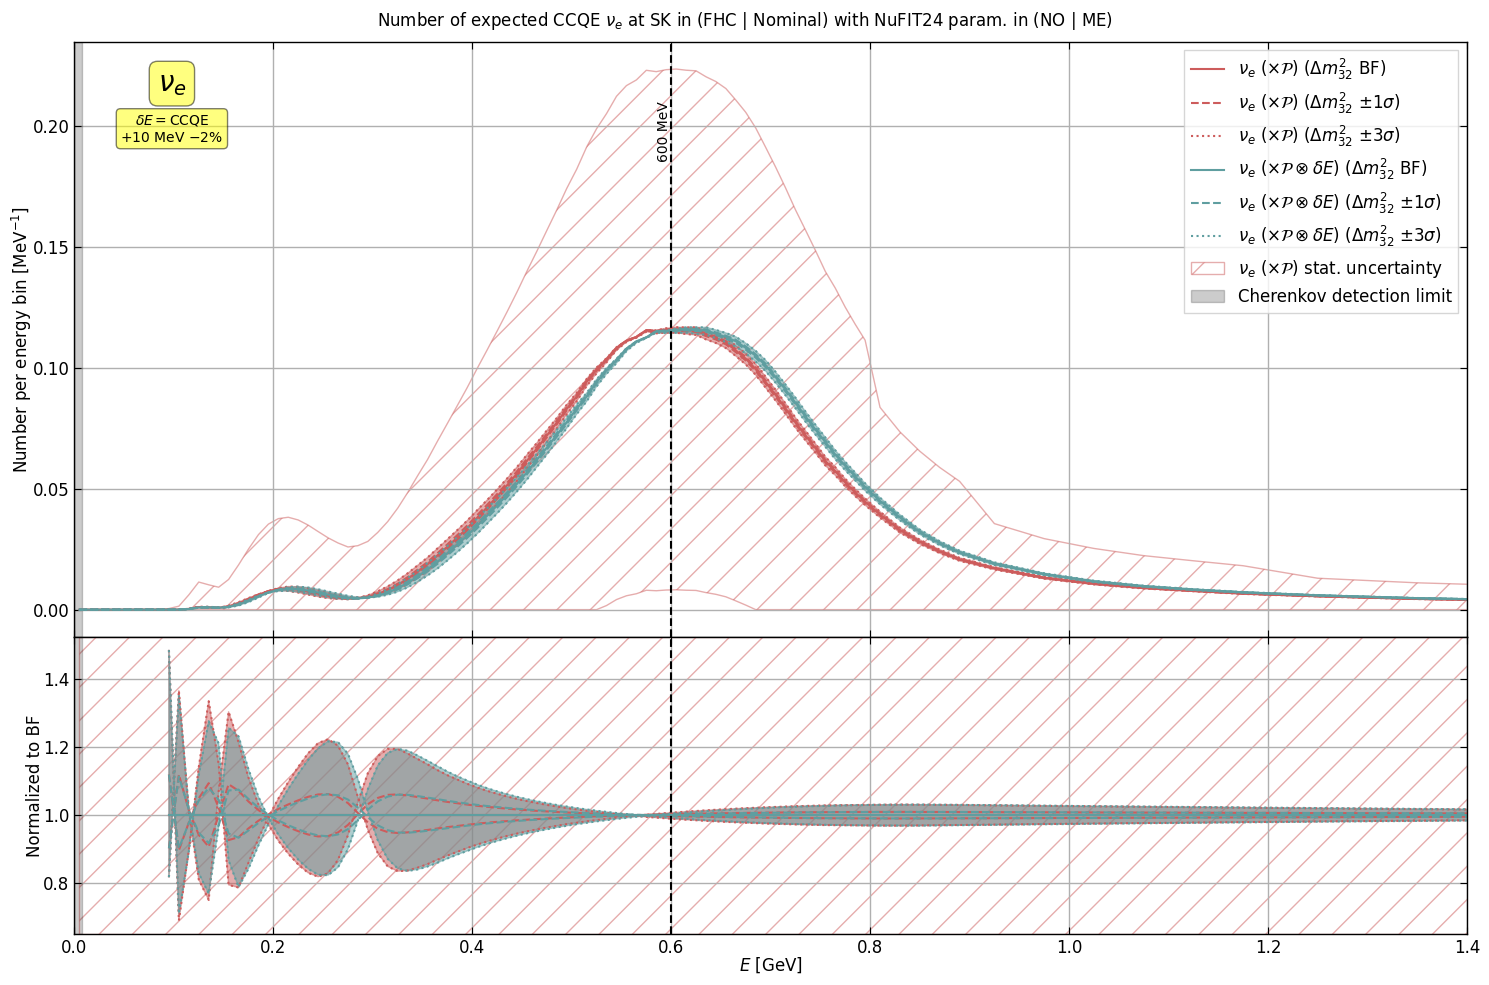

In [12]:
conv.oscillated_plot(
    number_oscillated=number_oscillated,
    oscillated_smeared=oscillated_smeared,
    params=params,
    channel=r"$\nu_\mu$",
    resolution="CCQE\n" + r"$+10$ MeV $-2\%$",
    uncertainty=True,
)
conv.oscillated_plot(
    number_oscillated=number_oscillated,
    oscillated_smeared=oscillated_smeared,
    params=params,
    keys=["nue"],
    channel=r"$\nu_e$",
    resolution="CCQE\n" + r"$+10$ MeV $-2\%$",
    uncertainty=True,
)

In [13]:
new_bin = np.arange(0, 5, 0.05)

In [14]:
number_50MeV = pd.DataFrame({"minE": new_bin, "maxE": new_bin + 0.05})

In [15]:
number_50MeV

,minE,maxE
0,0.00,0.05
1,0.05,0.10
2,0.10,0.15
3,0.15,0.20
4,0.20,0.25
...,...,...
95,4.75,4.80
96,4.80,4.85
97,4.85,4.90
98,4.90,4.95


In [16]:
for key in ["numu", "nue", "nutau", "antinumu", "antinue", "antinutau"]:
    number_50MeV[key] = np.interp(
        x=(number_50MeV.minE + number_50MeV.maxE) / 2,
        xp=(number.minE + number.maxE) / 2,
        fp=(number[key]),
    )

In [17]:
for key in ["numu", "nue", "nutau", "antinumu", "antinue", "antinutau"]:
    new_integral = (number_50MeV[key] * (number_50MeV.maxE - number_50MeV.minE)).sum()
    true_integral = (number[key] * (number.maxE - number.minE)).sum()
    if new_integral != 0:
        number_50MeV[key] *= true_integral / new_integral

In [18]:
number_50MeV_oscillated = {
    "bf": conv.oscillate(to_oscillate=number_50MeV),
    "p1sigma": conv.oscillate(
        to_oscillate=number_50MeV, dm2_atm=param.NUFIT["Dm_square_32"]["p1sigma"]
    ),
    "m1sigma": conv.oscillate(
        to_oscillate=number_50MeV, dm2_atm=param.NUFIT["Dm_square_32"]["m1sigma"]
    ),
    "p3sigma": conv.oscillate(
        to_oscillate=number_50MeV, dm2_atm=param.NUFIT["Dm_square_32"]["p3sigma"]
    ),
    "m3sigma": conv.oscillate(
        to_oscillate=number_50MeV, dm2_atm=param.NUFIT["Dm_square_32"]["m3sigma"]
    ),
}

In [19]:
oscillated_50MeV_smeared = {}
for key in number_50MeV_oscillated:
    oscillated_50MeV_smeared[key] = conv.bias(
        input=number_50MeV_oscillated[key], a=0.02
    )

In [20]:
params = {
    "dm2_atm": [
        param.NUFIT["Dm_square_32"]["m3sigma"],
        param.NUFIT["Dm_square_32"]["p3sigma"],
    ]
}

number_50MeV_oscillated["min"], number_50MeV_oscillated["max"] = (
    number_50MeV_oscillated["m3sigma"],
    number_50MeV_oscillated["p3sigma"],
)
oscillated_50MeV_smeared["min"], oscillated_50MeV_smeared["max"] = (
    oscillated_50MeV_smeared["m3sigma"],
    oscillated_50MeV_smeared["p3sigma"],
)

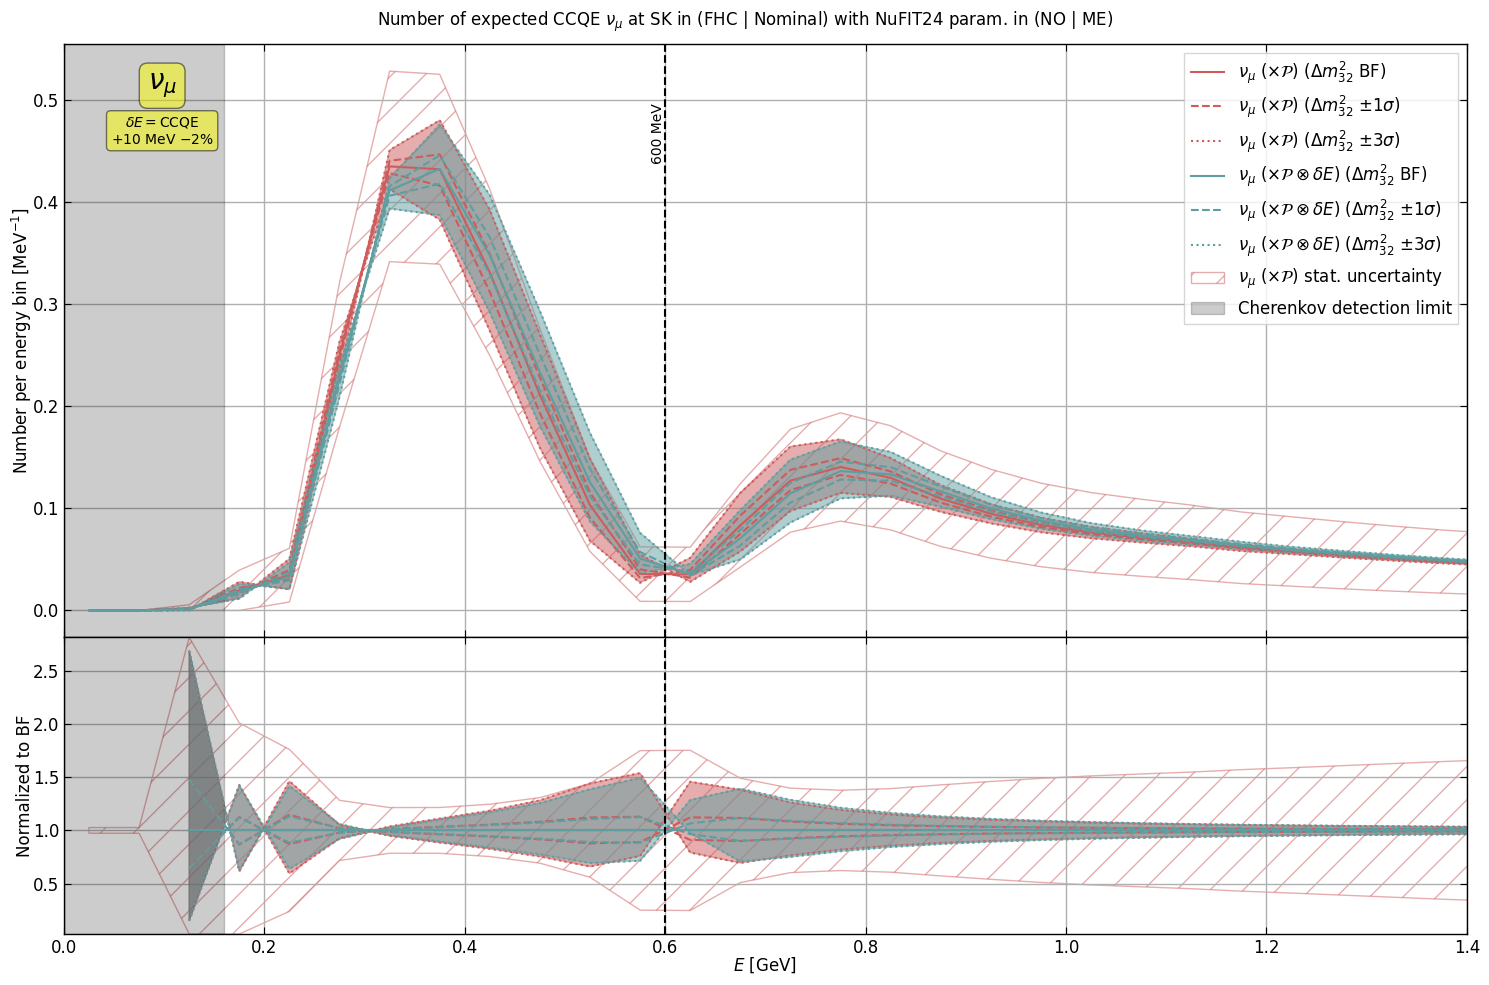

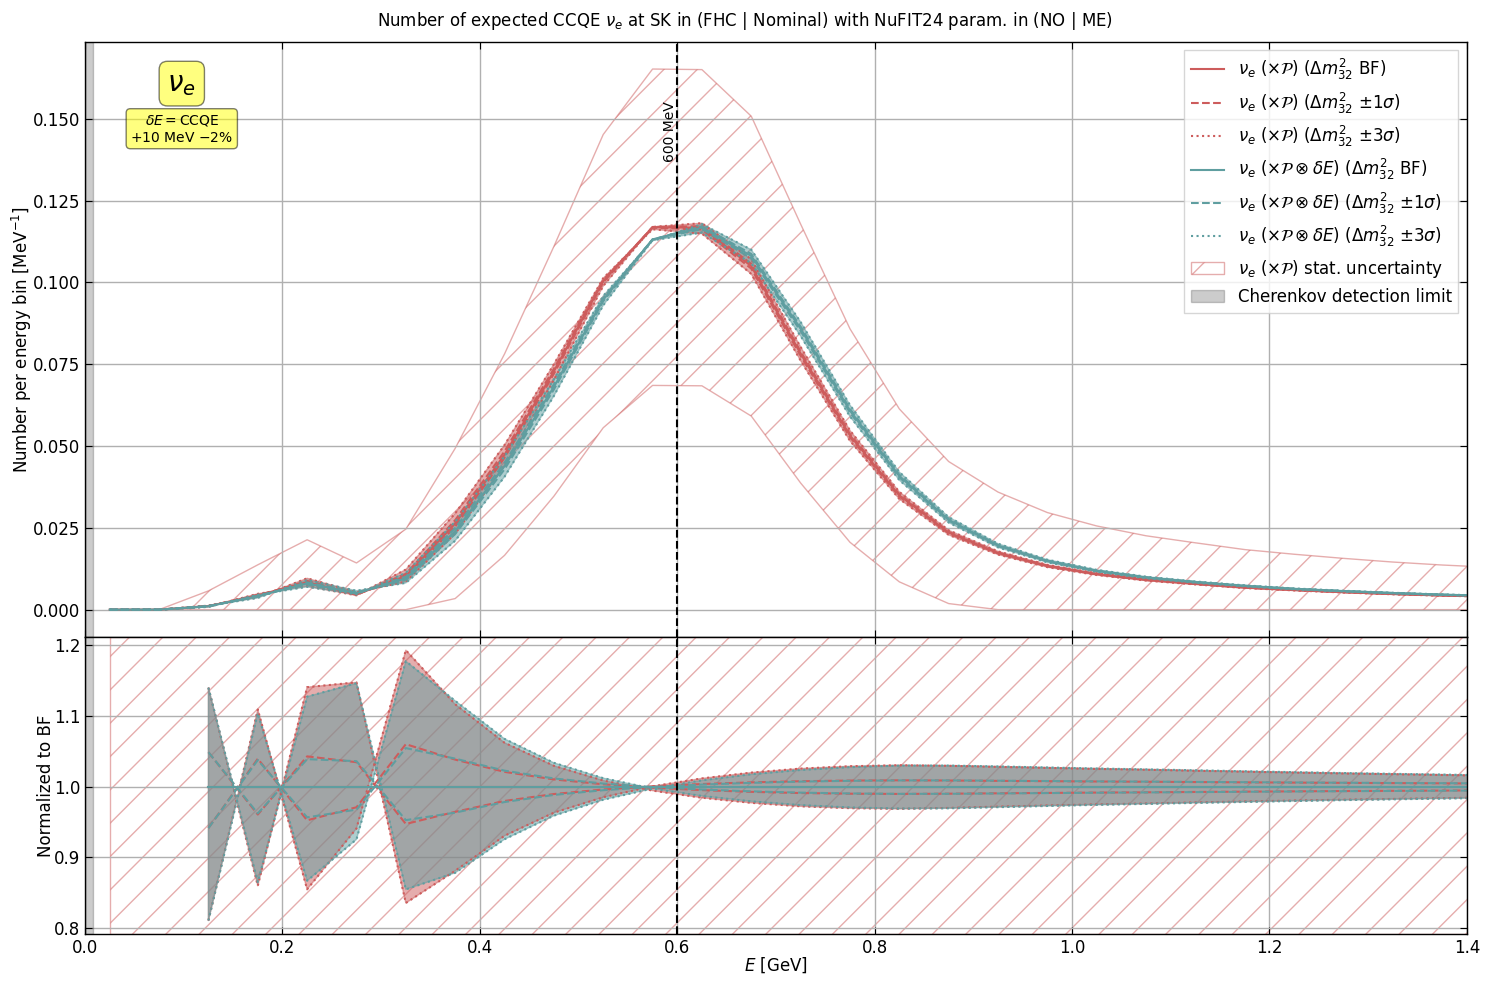

In [21]:
conv.oscillated_plot(
    number_oscillated=number_50MeV_oscillated,
    oscillated_smeared=oscillated_50MeV_smeared,
    params=params,
    channel=r"$\nu_\mu$",
    resolution="CCQE\n" + r"$+10$ MeV $-2\%$",
    uncertainty=True,
)
conv.oscillated_plot(
    number_oscillated=number_50MeV_oscillated,
    oscillated_smeared=oscillated_50MeV_smeared,
    params=params,
    keys=["nue"],
    channel=r"$\nu_e$",
    resolution="CCQE\n" + r"$+10$ MeV $-2\%$",
    uncertainty=True,
)